In [ ]:
 import kagglehub

path = kagglehub.dataset_download("manuldas/human-figure-drawing")

print("Path to dataset files:", path)

100%|██████████| 209M/209M [00:04<00:00, 52.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/manuldas/human-figure-drawing/versions/1


In [ ]:
import shutil
import os

In [ ]:


# Move the downloaded dataset to /content
new_path = "/content/human-figure-drawing"
os.makedirs(new_path, exist_ok=True)
shutil.move(path, new_path)

print("Dataset moved to:", new_path)


Dataset moved to: /content/human-figure-drawing


In [ ]:
mania = os.listdir("/content/human-figure-drawing/1/hfdt/Mania")
schizo = os.listdir("/content/human-figure-drawing/1/hfdt/Schizophrenia")

In [ ]:
len(mania)

108

In [ ]:
len(schizo)

122

In [ ]:
122+108

230

Training set: 207 images
Validation set: 23 images
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 63s 527ms/step - accuracy: 0.5633 - loss: 1.0404 - val_accuracy: 0.5217 - val_loss: 1.1668 - learning_rate: 1.0000e-04
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - accuracy: 0.6209 - loss: 0.9702 - val_accuracy: 0.5217 - val_loss: 1.4004 - learning_rate: 1.0000e-04
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.6873 - loss: 0.9293 - val_accuracy: 0.5217 - val_loss: 1.2590 - learning_rate: 1.0000e-04
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 220ms/step - accuracy: 0.6725 - loss: 0.9228 - val_accuracy: 0.5217 - val_loss: 1.2847 - learning_rate: 1.0000e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 132ms/step - accuracy: 0.6611 - loss: 0.9201 - val_accuracy: 0.5217 - val_loss: 1.2549 - learning_rate: 1.0000e-04
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 218ms/step - accuracy: 0.7574 - loss: 0.8760 - val_accuracy: 0.5217

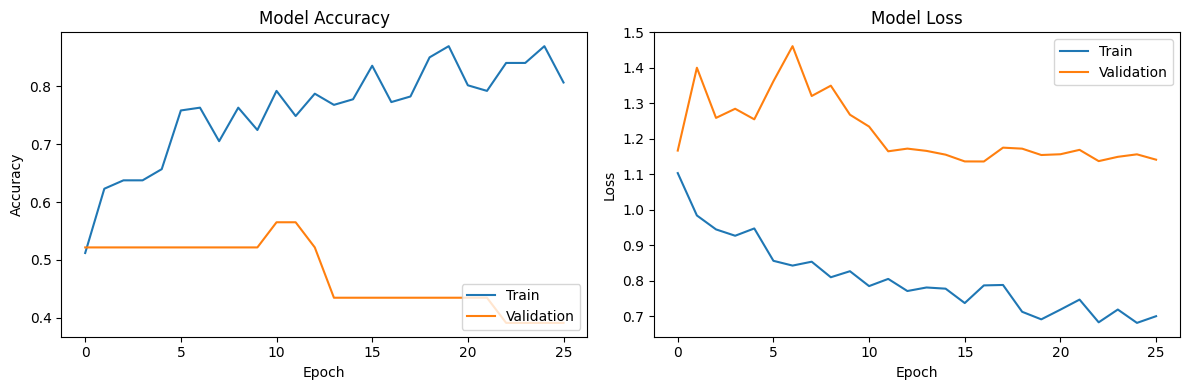

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import os
import random

# Data preparation (same as yours)
mania_dir = "/content/human-figure-drawing/1/hfdt/Mania"
schizo_dir = "/content/human-figure-drawing/1/hfdt/Schizophrenia"
mania_images = [os.path.join(mania_dir, img) for img in os.listdir(mania_dir)]
schizo_images = [os.path.join(schizo_dir, img) for img in os.listdir(schizo_dir)]
all_images = mania_images + schizo_images
labels = [0] * len(mania_images) + [1] * len(schizo_images)
combined = list(zip(all_images, labels))
random.shuffle(combined)
all_images, labels = zip(*combined)
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_images, labels, test_size=0.1, random_state=42, stratify=labels
)
print(f"Training set: {len(train_imgs)} images")
print(f"Validation set: {len(val_imgs)} images")

# Define preprocessing function with augmentation for training
IMG_SIZE = (224, 224)
BATCH_SIZE = 8  # Reduced batch size

def preprocess_train(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)

    # Apply augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    # Random rotation
    angle = tf.random.uniform([], -0.2, 0.2)
    image = tf.image.rot90(image, tf.cast(angle * 4, tf.int32))

    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

def preprocess_val(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Create datasets with appropriate preprocessing
train_ds = tf.data.Dataset.from_tensor_slices((train_imgs, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_imgs, val_labels))
train_ds = train_ds.map(preprocess_train).batch(BATCH_SIZE).shuffle(500).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_val).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create model with transfer learning
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# Freeze most of the base model
base_model.trainable = False
# Only make the last few layers trainable
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Build model with regularization
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs, outputs)

# Compile with lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Callbacks for training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001
    )
]

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,  # Will stop early due to early stopping
    callbacks=callbacks
)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import os
import random
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint

# Data preparation
mania_dir = "/content/human-figure-drawing/1/hfdt/Mania"
schizo_dir = "/content/human-figure-drawing/1/hfdt/Schizophrenia"
mania_images = [os.path.join(mania_dir, img) for img in os.listdir(mania_dir)]
schizo_images = [os.path.join(schizo_dir, img) for img in os.listdir(schizo_dir)]
all_images = mania_images + schizo_images
labels = [0] * len(mania_images) + [1] * len(schizo_images)
combined = list(zip(all_images, labels))
random.shuffle(combined)
all_images, labels = zip(*combined)

# Use more data for training, less for validation
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_images, labels, test_size=0.15, random_state=42, stratify=labels
)
print(f"Training set: {len(train_imgs)} images")
print(f"Validation set: {len(val_imgs)} images")

# Enhanced preprocessing function with more aggressive augmentation
IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # Increased batch size to improve generalization

def preprocess_train(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)

    # More aggressive augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_hue(image, max_delta=0.1)

    # Random rotation (more variation)
    angle = tf.random.uniform([], -0.3, 0.3)
    image = tf.image.rot90(image, tf.cast(angle * 4, tf.int32))

    # Random zoom
    crop_size = tf.random.uniform([], 0.8, 1.0, dtype=tf.float32)
    crop_size = tf.cast(tf.cast(IMG_SIZE[0], tf.float32) * crop_size, tf.int32)
    image = tf.image.random_crop(image, [crop_size, crop_size, 3])
    image = tf.image.resize(image, IMG_SIZE)

    # Random noise addition
    if tf.random.uniform([], 0, 1) > 0.7:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02)
        image = tf.clip_by_value(image + noise, 0, 255)

    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

def preprocess_val(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Create datasets with appropriate preprocessing
train_ds = tf.data.Dataset.from_tensor_slices((train_imgs, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_imgs, val_labels))

# Enhanced data pipeline with more cache/prefetch for better training
train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(buffer_size=1000)  # Larger shuffle buffer
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Create model with transfer learning - using a smaller model with fewer parameters
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# Freeze the entire base model to prevent overfitting
base_model.trainable = False

# Build a simpler model with stronger regularization
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)

# Smaller network with stronger regularization
x = Dense(64, activation="relu",
          kernel_regularizer=tf.keras.regularizers.l2(0.005), #control gradiant magnitude
          activity_regularizer=tf.keras.regularizers.l1(0.002))(x)
x = Dropout(0.6)(x)  # Higher dropout rate

outputs = Dense(1, activation="sigmoid",
               kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
model = Model(inputs, outputs)

# Use learning rate schedule to better control convergence
initial_learning_rate = 0.0002
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=20*len(train_imgs)//BATCH_SIZE,
    decay_rate=0.9
    )

# Compile with weight decay
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC()]
)

# Enhanced callbacks for training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=0.005
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=0.00001,
        min_delta=0.005
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # Class weights to handle any imbalance
    tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epoch, logs: print(f"Epoch {epoch+1} starting")
    )
]

# Calculate class weights to address any class imbalance
train_labels_array = np.array(train_labels)
class_weight = {
    0: len(train_labels_array) / (2 * np.sum(train_labels_array == 0)),
    1: len(train_labels_array) / (2 * np.sum(train_labels_array == 1))
}
print(f"Class weights: {class_weight}")

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150,  # More epochs with patience for early stopping
    callbacks=callbacks,
    class_weight=class_weight  # Using class weights for imbalance
)

# Load best model for evaluation
model.load_weights('best_model.h5')

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()

Training set: 195 images
Validation set: 35 images
5903360/5903360 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Class weights: {0: np.float64(1.059782608695652), 1: np.float64(0.9466019417475728)}
Epoch 1 starting
Epoch 1/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.5128 - auc: 0.5820 - loss: 2.0855
Epoch 1: val_loss improved from inf to 1.49870, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5219 - auc: 0.5743 - loss: 2.0400 - val_accuracy: 0.5714 - val_auc: 0.6217 - val_loss: 1.4987 - learning_rate: 2.0000e-04
Epoch 2 starting
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5181 - auc: 0.5632 - loss: 1.5057
Epoch 2: val_loss improved from 1.49870 to 1.33952, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 476ms/step - accuracy: 0.5195 - auc: 0.5632 - loss: 1.5019 - val_accuracy: 0.5714 - val_auc: 0.5345 - val_loss: 1.3395 - learning_rate: 2.0000e-04
Epoch 3 starting
Epoch 3/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4993 - auc: 0.4909 - loss: 1.3671
Epoch 3: val_loss improved from 1.33952 to 1.27544, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 472ms/step - accuracy: 0.5075 - auc: 0.5047 - loss: 1.3547 - val_accuracy: 0.5714 - val_auc: 0.5280 - val_loss: 1.2754 - learning_rate: 2.0000e-04
Epoch 4 starting
Epoch 4/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6239 - auc: 0.6061 - loss: 1.2480
Epoch 4: val_loss improved from 1.27544 to 1.21913, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 361ms/step - accuracy: 0.6204 - auc: 0.6114 - loss: 1.2461 - val_accuracy: 0.5714 - val_auc: 0.6086 - val_loss: 1.2191 - learning_rate: 2.0000e-04
Epoch 5 starting
Epoch 5/150
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5161 - auc: 0.5855 - loss: 1.2087
Epoch 5: val_loss improved from 1.21913 to 1.18064, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - accuracy: 0.5322 - auc: 0.5971 - loss: 1.2051 - val_accuracy: 0.5714 - val_auc: 0.6118 - val_loss: 1.1806 - learning_rate: 2.0000e-04
Epoch 6 starting
Epoch 6/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6442 - auc: 0.6113 - loss: 1.1745
Epoch 6: val_loss improved from 1.18064 to 1.14682, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6497 - auc: 0.6287 - loss: 1.1698 - val_accuracy: 0.6000 - val_auc: 0.6661 - val_loss: 1.1468 - learning_rate: 2.0000e-04
Epoch 7 starting
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6136 - auc: 0.6726 - loss: 1.1316
Epoch 7: val_loss improved from 1.14682 to 1.11678, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step - accuracy: 0.6119 - auc: 0.6702 - loss: 1.1309 - val_accuracy: 0.6571 - val_auc: 0.6645 - val_loss: 1.1168 - learning_rate: 2.0000e-04
Epoch 8 starting
Epoch 8/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6981 - auc: 0.6890 - loss: 1.0899
Epoch 8: val_loss improved from 1.11678 to 1.08246, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 443ms/step - accuracy: 0.6853 - auc: 0.6867 - loss: 1.0901 - val_accuracy: 0.6571 - val_auc: 0.6826 - val_loss: 1.0825 - learning_rate: 2.0000e-04
Epoch 9 starting
Epoch 9/150
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6559 - auc: 0.6611 - loss: 1.0716
Epoch 9: val_loss improved from 1.08246 to 1.05716, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 473ms/step - accuracy: 0.6460 - auc: 0.6615 - loss: 1.0704 - val_accuracy: 0.6286 - val_auc: 0.7220 - val_loss: 1.0572 - learning_rate: 2.0000e-04
Epoch 10 starting
Epoch 10/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6351 - auc: 0.6063 - loss: 1.0496
Epoch 10: val_loss improved from 1.05716 to 1.03705, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 480ms/step - accuracy: 0.6387 - auc: 0.6229 - loss: 1.0467 - val_accuracy: 0.6857 - val_auc: 0.7220 - val_loss: 1.0370 - learning_rate: 2.0000e-04
Epoch 11 starting
Epoch 11/150
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6821 - auc: 0.6940 - loss: 1.0177
Epoch 11: val_loss improved from 1.03705 to 1.02073, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6692 - auc: 0.6888 - loss: 1.0155 - val_accuracy: 0.6286 - val_auc: 0.7089 - val_loss: 1.0207 - learning_rate: 2.0000e-04
Epoch 12 starting
Epoch 12/150
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6873 - auc: 0.7282 - loss: 0.9975
Epoch 12: val_loss improved from 1.02073 to 1.00026, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 448ms/step - accuracy: 0.6869 - auc: 0.7314 - loss: 0.9951 - val_accuracy: 0.6286 - val_auc: 0.7039 - val_loss: 1.0003 - learning_rate: 2.0000e-04
Epoch 13 starting
Epoch 13/150
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6940 - auc: 0.7259 - loss: 0.9742
Epoch 13: val_loss improved from 1.00026 to 0.98397, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6844 - auc: 0.7232 - loss: 0.9743 - val_accuracy: 0.6286 - val_auc: 0.6957 - val_loss: 0.9840 - learning_rate: 2.0000e-04
Epoch 14 starting
Epoch 14/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6954 - auc: 0.7363 - loss: 0.9583
Epoch 14: val_loss improved from 0.98397 to 0.97136, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 364ms/step - accuracy: 0.6902 - auc: 0.7314 - loss: 0.9579 - val_accuracy: 0.6000 - val_auc: 0.7072 - val_loss: 0.9714 - learning_rate: 2.0000e-04
Epoch 15 starting
Epoch 15/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6840 - auc: 0.7327 - loss: 0.9425
Epoch 15: val_loss improved from 0.97136 to 0.96875, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 473ms/step - accuracy: 0.6828 - auc: 0.7310 - loss: 0.9428 - val_accuracy: 0.6857 - val_auc: 0.7171 - val_loss: 0.9688 - learning_rate: 2.0000e-04
Epoch 16 starting
Epoch 16/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6620 - auc: 0.7149 - loss: 0.9381
Epoch 16: val_loss improved from 0.96875 to 0.94931, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 474ms/step - accuracy: 0.6612 - auc: 0.7134 - loss: 0.9381 - val_accuracy: 0.6000 - val_auc: 0.7171 - val_loss: 0.9493 - learning_rate: 2.0000e-04
Epoch 17 starting
Epoch 17/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7167 - auc: 0.7839 - loss: 0.9104
Epoch 17: val_loss improved from 0.94931 to 0.93823, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - accuracy: 0.7138 - auc: 0.7799 - loss: 0.9109 - val_accuracy: 0.6286 - val_auc: 0.7072 - val_loss: 0.9382 - learning_rate: 2.0000e-04
Epoch 18 starting
Epoch 18/150
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7240 - auc: 0.7818 - loss: 0.8990
Epoch 18: val_loss improved from 0.93823 to 0.92977, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.7187 - auc: 0.7770 - loss: 0.8997 - val_accuracy: 0.6857 - val_auc: 0.7352 - val_loss: 0.9298 - learning_rate: 2.0000e-04
Epoch 19 starting
Epoch 19/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7147 - auc: 0.7934 - loss: 0.8856
Epoch 19: val_loss improved from 0.92977 to 0.91757, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - accuracy: 0.7168 - auc: 0.7901 - loss: 0.8863 - val_accuracy: 0.6857 - val_auc: 0.7451 - val_loss: 0.9176 - learning_rate: 1.8000e-04
Epoch 20 starting
Epoch 20/150
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6087 - auc: 0.6942 - loss: 0.8969
Epoch 20: val_loss improved from 0.91757 to 0.91015, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 475ms/step - accuracy: 0.6187 - auc: 0.7031 - loss: 0.8951 - val_accuracy: 0.7143 - val_auc: 0.7303 - val_loss: 0.9101 - learning_rate: 1.8000e-04
Epoch 21 starting
Epoch 21/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7373 - auc: 0.7213 - loss: 0.8915
Epoch 21: val_loss improved from 0.91015 to 0.90267, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 447ms/step - accuracy: 0.7334 - auc: 0.7232 - loss: 0.8909 - val_accuracy: 0.7143 - val_auc: 0.7368 - val_loss: 0.9027 - learning_rate: 1.8000e-04
Epoch 22 starting
Epoch 22/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6621 - auc: 0.7564 - loss: 0.8738
Epoch 22: val_loss improved from 0.90267 to 0.88915, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 364ms/step - accuracy: 0.6742 - auc: 0.7620 - loss: 0.8729 - val_accuracy: 0.6857 - val_auc: 0.7582 - val_loss: 0.8891 - learning_rate: 1.8000e-04
Epoch 23 starting
Epoch 23/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7491 - auc: 0.8142 - loss: 0.8501
Epoch 23: val_loss improved from 0.88915 to 0.88723, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step - accuracy: 0.7484 - auc: 0.8130 - loss: 0.8503 - val_accuracy: 0.6857 - val_auc: 0.7434 - val_loss: 0.8872 - learning_rate: 1.8000e-04
Epoch 24 starting
Epoch 24/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7690 - auc: 0.8146 - loss: 0.8490
Epoch 24: val_loss did not improve from 0.88723
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 450ms/step - accuracy: 0.7665 - auc: 0.8125 - loss: 0.8496 - val_accuracy: 0.6857 - val_auc: 0.7484 - val_loss: 0.8876 - learning_rate: 1.8000e-04
Epoch 25 starting
Epoch 25/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7339 - auc: 0.7374 - loss: 0.8380
Epoch 25: val_loss improved from 0.88723 to 0.87398, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 447ms/step - accuracy: 0.7320 - auc: 0.7413 - loss: 0.8376 - val_accuracy: 0.7143 - val_auc: 0.7368 - val_loss: 0.8740 - learning_rate: 1.8000e-04
Epoch 26 starting
Epoch 26/150
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7430 - auc: 0.8470 - loss: 0.8355
Epoch 26: val_loss improved from 0.87398 to 0.87054, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 476ms/step - accuracy: 0.7350 - auc: 0.8368 - loss: 0.8365 - val_accuracy: 0.7143 - val_auc: 0.7204 - val_loss: 0.8705 - learning_rate: 1.8000e-04
Epoch 27 starting
Epoch 27/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8347 - auc: 0.8455 - loss: 0.8304
Epoch 27: val_loss improved from 0.87054 to 0.86524, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.8258 - auc: 0.8430 - loss: 0.8305 - val_accuracy: 0.7143 - val_auc: 0.7401 - val_loss: 0.8652 - learning_rate: 1.8000e-04
Epoch 28 starting
Epoch 28/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7850 - auc: 0.8504 - loss: 0.8280
Epoch 28: val_loss improved from 0.86524 to 0.86174, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - accuracy: 0.7839 - auc: 0.8490 - loss: 0.8281 - val_accuracy: 0.7429 - val_auc: 0.7434 - val_loss: 0.8617 - learning_rate: 1.8000e-04
Epoch 29 starting
Epoch 29/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7548 - auc: 0.8408 - loss: 0.8178
Epoch 29: val_loss improved from 0.86174 to 0.85540, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 377ms/step - accuracy: 0.7547 - auc: 0.8402 - loss: 0.8176 - val_accuracy: 0.7143 - val_auc: 0.7418 - val_loss: 0.8554 - learning_rate: 1.8000e-04
Epoch 30 starting
Epoch 30/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8169 - auc: 0.8463 - loss: 0.8093
Epoch 30: val_loss did not improve from 0.85540
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 445ms/step - accuracy: 0.8034 - auc: 0.8402 - loss: 0.8089 - val_accuracy: 0.6857 - val_auc: 0.7319 - val_loss: 0.8630 - learning_rate: 1.8000e-04
Epoch 31 starting
Epoch 31/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7195 - auc: 0.8505 - loss: 0.8102
Epoch 31: val_loss improved from 0.85540 to 0.84827, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 473ms/step - accuracy: 0.7336 - auc: 0.8520 - loss: 0.8080 - val_accuracy: 0.7143 - val_auc: 0.7467 - val_loss: 0.8483 - learning_rate: 1.8000e-04
Epoch 32 starting
Epoch 32/150
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7841 - auc: 0.8658 - loss: 0.8078
Epoch 32: val_loss did not improve from 0.84827
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - accuracy: 0.7722 - auc: 0.8519 - loss: 0.8059 - val_accuracy: 0.7429 - val_auc: 0.7385 - val_loss: 0.8498 - learning_rate: 1.8000e-04
Epoch 33 starting
Epoch 33/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7493 - auc: 0.8363 - loss: 0.7867
Epoch 33: val_loss improved from 0.84827 to 0.84481, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 421ms/step - accuracy: 0.7496 - auc: 0.8370 - loss: 0.7870 - val_accuracy: 0.7143 - val_auc: 0.7286 - val_loss: 0.8448 - learning_rate: 1.8000e-04
Epoch 34 starting
Epoch 34/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7742 - auc: 0.8389 - loss: 0.7946
Epoch 34: val_loss improved from 0.84481 to 0.84286, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 441ms/step - accuracy: 0.7755 - auc: 0.8386 - loss: 0.7938 - val_accuracy: 0.7143 - val_auc: 0.7237 - val_loss: 0.8429 - learning_rate: 1.8000e-04
Epoch 35 starting
Epoch 35/150
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7907 - auc: 0.8798 - loss: 0.7721
Epoch 35: val_loss improved from 0.84286 to 0.84080, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 364ms/step - accuracy: 0.7848 - auc: 0.8709 - loss: 0.7737 - val_accuracy: 0.7429 - val_auc: 0.7155 - val_loss: 0.8408 - learning_rate: 1.8000e-04
Epoch 36 starting
Epoch 36/150
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8320 - auc: 0.8686 - loss: 0.7823
Epoch 36: val_loss improved from 0.84080 to 0.83817, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 470ms/step - accuracy: 0.8233 - auc: 0.8675 - loss: 0.7812 - val_accuracy: 0.6857 - val_auc: 0.7319 - val_loss: 0.8382 - learning_rate: 1.8000e-04
Epoch 37 starting
Epoch 37/150
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7577 - auc: 0.8137 - loss: 0.7981
Epoch 37: val_loss did not improve from 0.83817
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 446ms/step - accuracy: 0.7638 - auc: 0.8200 - loss: 0.7937 - val_accuracy: 0.6857 - val_auc: 0.7303 - val_loss: 0.8393 - learning_rate: 1.8000e-04
Epoch 38 starting
Epoch 38/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7516 - auc: 0.8407 - loss: 0.7555
Epoch 38: val_loss improved from 0.83817 to 0.83558, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 365ms/step - accuracy: 0.7476 - auc: 0.8384 - loss: 0.7568 - val_accuracy: 0.7429 - val_auc: 0.7352 - val_loss: 0.8356 - learning_rate: 1.6200e-04
Epoch 39 starting
Epoch 39/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6762 - auc: 0.7728 - loss: 0.7886
Epoch 39: val_loss improved from 0.83558 to 0.82716, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 473ms/step - accuracy: 0.6894 - auc: 0.7873 - loss: 0.7833 - val_accuracy: 0.8000 - val_auc: 0.7303 - val_loss: 0.8272 - learning_rate: 1.6200e-04
Epoch 40 starting
Epoch 40/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8095 - auc: 0.8740 - loss: 0.7502
Epoch 40: val_loss did not improve from 0.82716
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 446ms/step - accuracy: 0.8081 - auc: 0.8735 - loss: 0.7501 - val_accuracy: 0.7143 - val_auc: 0.7138 - val_loss: 0.8312 - learning_rate: 1.6200e-04
Epoch 41 starting
Epoch 41/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7790 - auc: 0.8748 - loss: 0.7373
Epoch 41: val_loss did not improve from 0.82716
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 450ms/step - accuracy: 0.7780 - auc: 0.8732 - loss: 0.7384 - val_accuracy: 0.6857 - val_auc: 0.6711 - val_loss: 0.8401 - learning_rate: 1.6200e-04
Epoch 42 starting
Epoch 42/150
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7497 - auc: 0.8173 - loss: 0.7564
Epoch 42: val_l

TypeError: This optimizer was created with a `LearningRateSchedule` object as its `learning_rate` constructor argument, hence its learning rate is not settable. If you need the learning rate to be settable, you should instantiate the optimizer with a float `learning_rate` argument.

Training set: 195 images
Validation set: 35 images
Class weights: {0: np.float64(1.059782608695652), 1: np.float64(0.9466019417475728)}
Epoch 1 starting
Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.4887 - auc_1: 0.4409 - loss: 2.0771
Epoch 1: val_loss improved from inf to 1.54913, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.4871 - auc_1: 0.4407 - loss: 2.0662 - val_accuracy: 0.3714 - val_auc_1: 0.3438 - val_loss: 1.5491 - learning_rate: 2.0000e-04
Epoch 2 starting
Epoch 2/150
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4695 - auc_1: 0.5266 - loss: 1.4916
Epoch 2: val_loss improved from 1.54913 to 1.34399, saving model to best_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 374ms/step - accuracy: 0.4740 - auc_1: 0.5250 - loss: 1.4829 - val_accuracy: 0.5429 - val_auc_1: 0.4375 - val_loss: 1.3440 - learning_rate: 2.0000e-04
Epoch 3 starting
Epoch 3/150
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5669 - auc_1: 0

KeyError: 'auc'

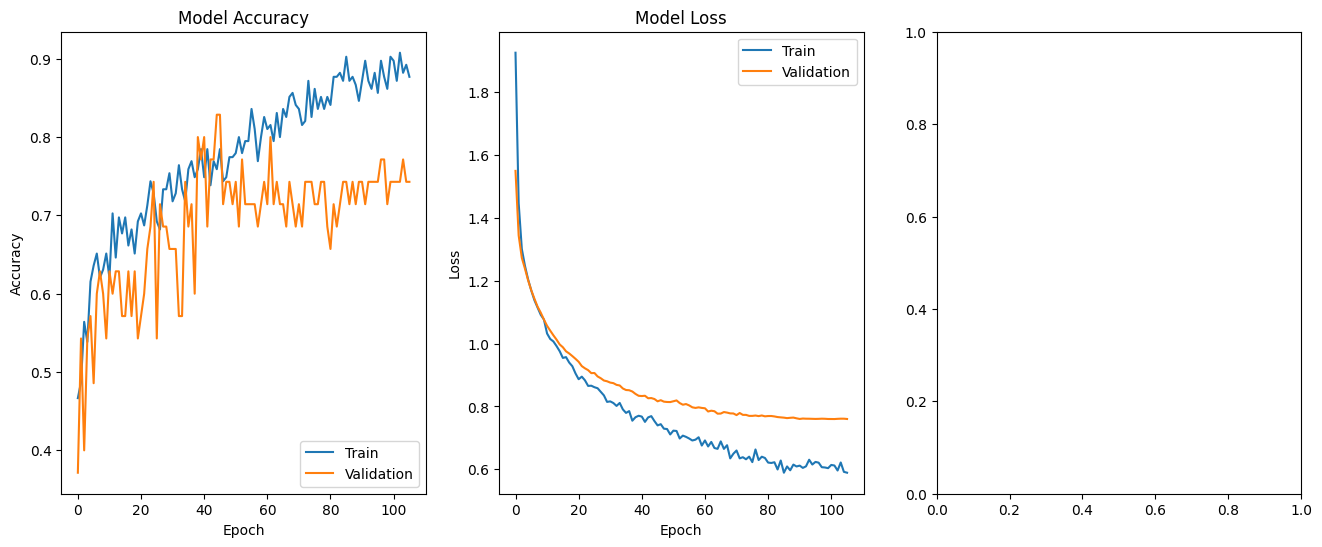

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import os
import random
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint

# Data preparation
mania_dir = "/content/human-figure-drawing/1/hfdt/Mania"
schizo_dir = "/content/human-figure-drawing/1/hfdt/Schizophrenia"
mania_images = [os.path.join(mania_dir, img) for img in os.listdir(mania_dir)]
schizo_images = [os.path.join(schizo_dir, img) for img in os.listdir(schizo_dir)]
all_images = mania_images + schizo_images
labels = [0] * len(mania_images) + [1] * len(schizo_images)
combined = list(zip(all_images, labels))
random.shuffle(combined)
all_images, labels = zip(*combined)

train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_images, labels, test_size=0.15, random_state=42, stratify=labels
)
print(f"Training set: {len(train_imgs)} images")
print(f"Validation set: {len(val_imgs)} images")

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

def preprocess_train(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_hue(image, max_delta=0.1)

    angle = tf.random.uniform([], -0.3, 0.3)
    image = tf.image.rot90(image, tf.cast(angle * 4, tf.int32))

    crop_size = tf.random.uniform([], 0.8, 1.0, dtype=tf.float32)
    crop_size = tf.cast(tf.cast(IMG_SIZE[0], tf.float32) * crop_size, tf.int32)
    image = tf.image.random_crop(image, [crop_size, crop_size, 3])
    image = tf.image.resize(image, IMG_SIZE)

    if tf.random.uniform([], 0, 1) > 0.7:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02)
        image = tf.clip_by_value(image + noise, 0, 255)

    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

def preprocess_val(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_imgs, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_imgs, val_labels))

train_ds = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet", alpha=0.75)

base_model.trainable = False
#front or top defining
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

x = Dense(64, activation="relu",
           kernel_regularizer=tf.keras.regularizers.l2(0.005),
          activity_regularizer=tf.keras.regularizers.l1(0.002))(x)
x = Dropout(0.6)(x)

outputs = Dense(1, activation="sigmoid",
               kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
model = Model(inputs, outputs)

initial_learning_rate = 0.0002

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, clipnorm=1.0)
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC()]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=0.005
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=0.00001,
        min_delta=0.005
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epoch, logs: print(f"Epoch {epoch+1} starting")
    )
]

train_labels_array = np.array(train_labels)
class_weight = {
    0: len(train_labels_array) / (2 * np.sum(train_labels_array == 0)),
    1: len(train_labels_array) / (2 * np.sum(train_labels_array == 1))
}
print(f"Class weights: {class_weight}")

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150,
    callbacks=callbacks,
    class_weight=class_weight  # Using class weights for imbalance
)

# Load best model for evaluation
model.load_weights('best_model.keras')



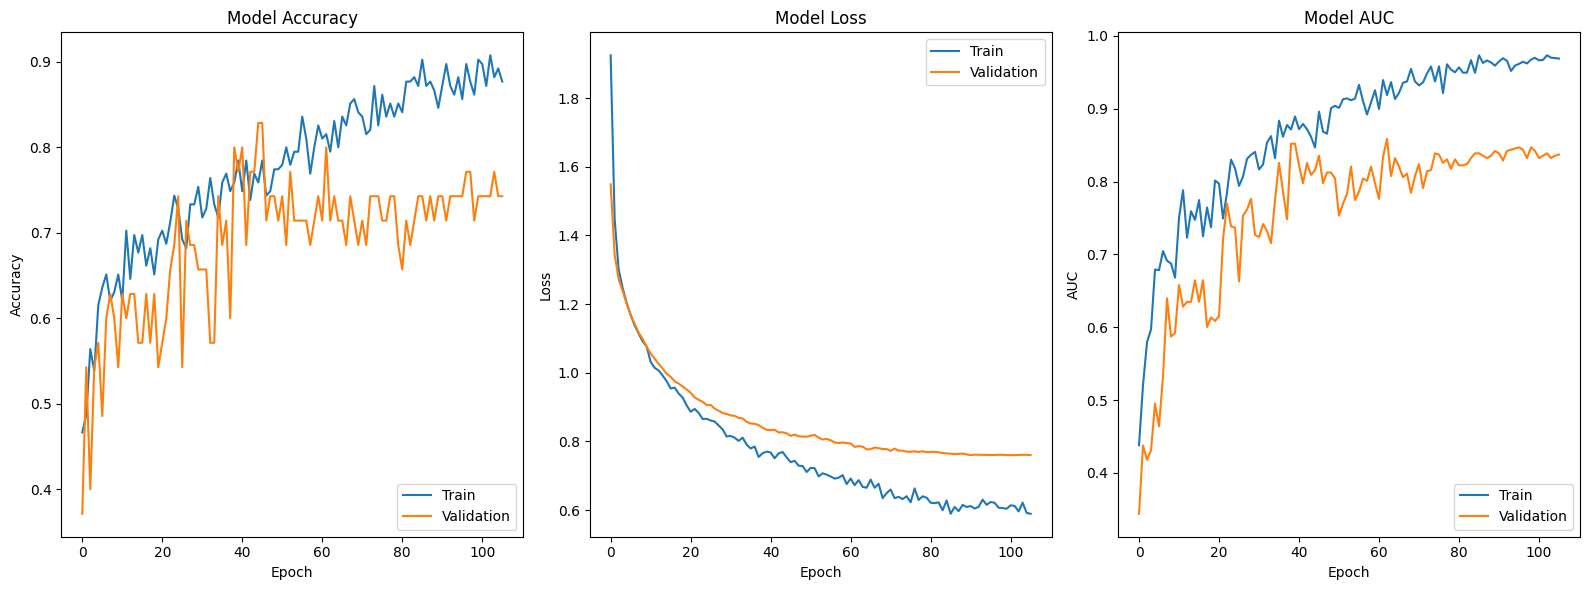

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 3, 3)
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step


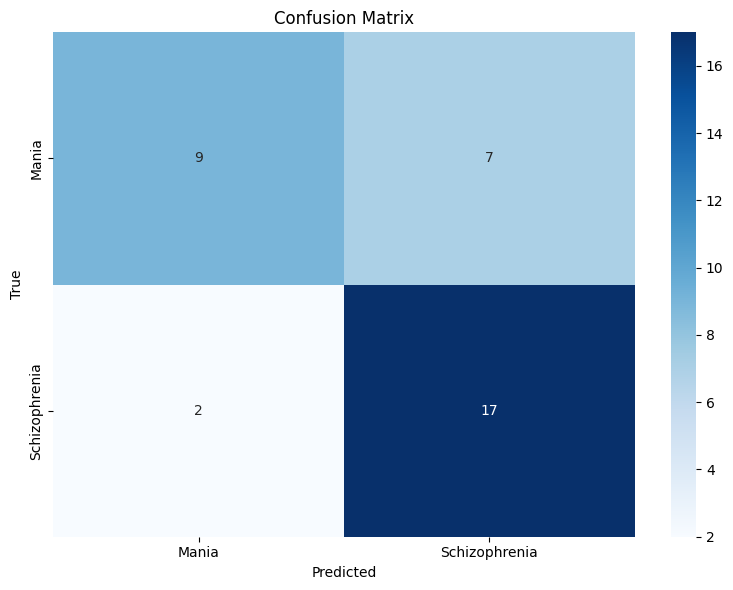

Classification Report:
               precision    recall  f1-score   support

        Mania       0.82      0.56      0.67        16
Schizophrenia       0.71      0.89      0.79        19

     accuracy                           0.74        35
    macro avg       0.76      0.73      0.73        35
 weighted avg       0.76      0.74      0.73        35

Accuracy: 0.7429
Precision: 0.7083
Recall: 0.8947
F1 Score: 0.7907


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a function to get predictions from the validation dataset
def get_predictions(model, dataset):
    y_true = []
    y_pred = []

    # Iterate through validation batches
    for images, labels in dataset:
        # Get predictions
        predictions = model.predict(images)
        # Convert probabilities to binary predictions
        binary_predictions = (predictions > 0.5).astype(int)

        # Append batch results to lists
        y_true.extend(labels.numpy())
        y_pred.extend(binary_predictions.flatten())

    return np.array(y_true), np.array(y_pred)

# Step 2: Get predictions
y_true, y_pred = get_predictions(model, val_ds)

# Step 3: Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Display confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Mania', 'Schizophrenia'],
            yticklabels=['Mania', 'Schizophrenia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Step 5: Print classification metrics
print("Classification Report:")
print(classification_report(y_true, y_pred,
                           target_names=['Mania', 'Schizophrenia']))

# Step 6: Print accuracy, precision, recall values
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


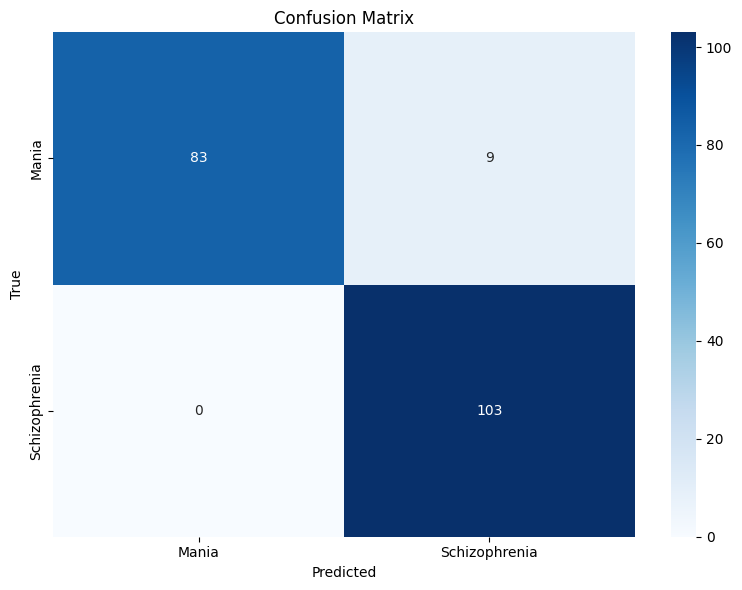

Classification Report:
               precision    recall  f1-score   support

        Mania       1.00      0.90      0.95        92
Schizophrenia       0.92      1.00      0.96       103

     accuracy                           0.95       195
    macro avg       0.96      0.95      0.95       195
 weighted avg       0.96      0.95      0.95       195

Accuracy: 0.9538
Precision: 0.9196
Recall: 1.0000
F1 Score: 0.9581


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create a function to get predictions from the validation dataset
def get_predictions(model, dataset):
    y_true = []
    y_pred = []

    # Iterate through validation batches
    for images, labels in dataset:
        # Get predictions
        predictions = model.predict(images)
        # Convert probabilities to binary predictions
        binary_predictions = (predictions > 0.5).astype(int)

        # Append batch results to lists
        y_true.extend(labels.numpy())
        y_pred.extend(binary_predictions.flatten())

    return np.array(y_true), np.array(y_pred)

# Step 2: Get predictions
y_true, y_pred = get_predictions(model, train_ds)

# Step 3: Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Display confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Mania', 'Schizophrenia'],
            yticklabels=['Mania', 'Schizophrenia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Step 5: Print classification metrics
print("Classification Report:")
print(classification_report(y_true, y_pred,
                           target_names=['Mania', 'Schizophrenia']))

# Step 6: Print accuracy, precision, recall values
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
loaded_model = tf.keras.models.load_model('best_model.keras')

In [ ]:
loaded_model.evaluate(val_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7074 - auc_1: 0.8459 - loss: 0.7651


[0.7598978877067566, 0.7428571581840515, 0.8355263471603394]